## インポート

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(1234)

## データの読み込み

In [2]:
df = pd.read_csv('chap05/input/data-attendance-2.txt')
df.head()

,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23


## モデル式の記述

$\lambda[n] = \exp(\beta_1 + \beta_2 A[n] + \beta_3 Score[n]) $

$M[n]$ ~ $ Poirsson( \lambda[n] )$

## Stanでの実装

In [3]:
model_code="""
data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=0> M[N];
}
parameters {
  real b1;
  real b2;
  real b3;
}
transformed parameters {
  real lambda[N];
  for (n in 1:N)
    lambda[n] = exp(b1 + b2*A[n] + b3*Score[n]);
}
model {
  for (n in 1:N)
    M[n] ~ poisson(lambda[n]);
}
generated quantities {
  int M_pred[N];
  for (n in 1:N)
    M_pred[n] = poisson_rng(lambda[n]);
}
"""

from pystan import StanModel
data = dict(N=df.shape[0], A=df.A, Score=df.Score/200, M=df.M)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_150bf7d9aaeff585eb332c7a581df661 NOW.


Inference for Stan model: anon_model_150bf7d9aaeff585eb332c7a581df661.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           3.58  2.5e-3    0.1   3.39   3.51   3.58   3.64   3.77   1449    1.0
b2           0.26  9.8e-4   0.04   0.18   0.24   0.26   0.29   0.35   1853    1.0
b3           0.29  3.9e-3   0.15  -0.01   0.19   0.29   0.39   0.57   1480    1.0
lambda[0]   39.62    0.05   1.96  35.94  38.28  39.57  40.86  43.67   1534    1.0
lambda[1]   57.53    0.04   1.99  53.71  56.21  57.54  58.83  61.59   2005    1.0
lambda[2]   42.91    0.02   1.22  40.61  42.09  42.92  43.71  45.34   2748    1.0
lambda[3]   52.85    0.05   2.18   48.7  51.34  52.83  54.27  57.36   1926    1.0
lambda[4]   58.63    0.06   2.35  54.05  57.06  58.62  60.15   63.4   1809    1.0
lambda[5]   43.41    0.02   1.27  40.99  42.54   43.4  44.28  45.95   279

# 実測値と予測値のプロット
* 80% 予測区間

In [5]:
ms = fit.extract()

qua = np.percentile(ms['M_pred'], q=[20, 50, 80], axis=0)
d_qua = pd.DataFrame(qua.T, 
                     columns=['p'+str(p) for p in [20, 50, 80]])
df_pred = df.join(d_qua)

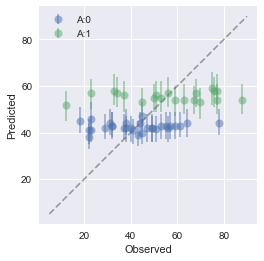

In [10]:
# 実測値と予測値の散布図
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for a, df_sub in df_pred.groupby(by='A'):
    ax.errorbar(x=df_sub.M, y=df_sub.p50, 
                yerr=[df_sub.p50-df_sub.p20, df_sub.p80-df_sub.p50],
                fmt='o', ms=8, alpha=0.5, marker='o', label='A:'+str(a))
ax.legend()
ax.set_aspect('equal')
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.plot([5, 90], [5, 90], ls="--", c=".3", alpha=.5)

plt.show()